# Calculate likelihood per frame

In [139]:
%matplotlib inline
import pdb
import matplotlib.pyplot as plt
import os
import re
import numpy as np
import pickle
import IPython
import sys 
sys.path.append('..')
from extract_hmm_gmm_params.get_hmm_gmm import GetParam

In [140]:
lib_wav = 'data/lib-0001-fc-008-part.wav'
lib_txt = 'data/lib-0001-fc-008-part.txt'
lib_mfcc = 'data/lib-0001-fc-008-part.mfcc'

# lib_wav = 'data/lib-0001-fc-001.wav'
# lib_txt = 'data/lib-0001-fc-001.txt'
# lib_mfcc = 'data/lib-0001-fc-001.mfcc'

In [141]:
!cat data/lib-0001-fc-008-part.txt
# !cat data/lib-0001-fc-001.txt

THE RAIN CONTINUED FAST THOUGH NOT HEAVY

In [142]:
IPython.display.Audio(lib_wav)

## Load MFCC

In [108]:
%%bash
# /home/kaldi/src/featbin/compute-mfcc-feats --use-energy=false --sample-frequency=16000 \
# scp,p:data/lib-0001-fc-001.scp ark,t:data/lib-0001-fc-001.mfcc

/home/kaldi/src/featbin/compute-mfcc-feats --use-energy=false --sample-frequency=16000 scp,p:data/lib-0001-fc-001.scp ark,t:data/lib-0001-fc-001.mfcc 
LOG (compute-mfcc-feats[5.2.38~1-b82b8]:main():compute-mfcc-feats.cc:181)  Done 1 out of 1 utterances.


In [143]:
def load_mfcc(file):
    '''Load mfcc (txt) file for a single wav file'''
    with open(file, 'r') as f:
        lines = f.readlines()
    mfcc = [re.sub(r'\n|\]', '', i).strip().split(' ') for i in lines[1:]]    
    return np.array(mfcc).astype(np.float)
    
mfcc = load_mfcc(lib_mfcc)
print(mfcc.shape)
mfcc # (300x13)

(300, 13)


array([[  5.50168600e+01,  -2.61352000e+01,   1.11575300e+01, ...,
          1.18221500e+01,   5.88053200e+00,   3.71159900e+00],
       [  5.18446500e+01,  -2.14232300e+01,   5.29893200e+00, ...,
          7.43690100e+00,   1.95482600e+01,   1.31463700e+01],
       [  5.00931800e+01,  -1.66251900e+01,   3.69649900e+00, ...,
          9.49944200e+00,   1.00154100e+01,   1.33833800e+01],
       ..., 
       [  5.41820100e+01,  -1.15077600e+01,   5.37628700e-01, ...,
          7.74043800e+00,   1.94237400e+01,   1.80245800e+01],
       [  5.40556900e+01,  -9.53825900e+00,   1.21408900e-02, ...,
          1.83922600e+01,   2.94135400e+01,   1.59047900e+01],
       [  5.44750400e+01,  -8.54205700e+00,   4.51162300e+00, ...,
          1.41274000e+01,   7.18378500e+00,   5.97816000e+00]])

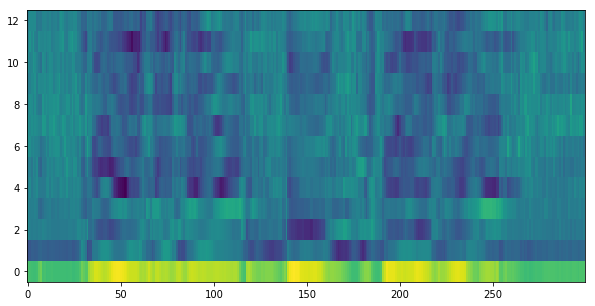

In [144]:
fig, ax = plt.subplots(figsize=(10,5), facecolor='white')
ax.imshow(mfcc.T, origin='lower', aspect='auto')

## Extract mfcc (39-d)

### (1) scp (wav) -> ark (13-d) -> ark (39-d)

In [8]:
%%bash
# /home/kaldi/src/featbin/compute-mfcc-feats --use-energy=false --sample-frequency=16000 \
# scp,p:data/lib-0001-fc-008-part.scp ark:data/lib-0001-fc-008-part.ark

/home/kaldi/src/featbin/compute-mfcc-feats --use-energy=false --sample-frequency=16000 scp,p:data/lib-0001-fc-008-part.scp ark:data/lib-0001-fc-008-part.ark 
LOG (compute-mfcc-feats[5.2.38~1-b82b8]:main():compute-mfcc-feats.cc:181)  Done 1 out of 1 utterances.


In [9]:
%%bash
# /home/kaldi/src/featbin/add-deltas ark:data/lib-0001-fc-008-part.ark ark:data/lib-0001-fc-008-part-39.ark

/home/kaldi/src/featbin/add-deltas ark:data/lib-0001-fc-008-part.ark ark:data/lib-0001-fc-008-part-39.ark 


### (2) scp (wav) -> ark (39-d)

In [145]:
%%bash
/home/kaldi/src/featbin/compute-mfcc-feats --use-energy=false --sample-frequency=16000 \
scp,p:data/lib-0001-fc-008-part.scp ark:- | \
/home/kaldi/src/featbin/add-deltas ark:- ark:data/lib-0001-fc-008-part-39.ark
# /home/kaldi/src/featbin/compute-mfcc-feats --use-energy=false --sample-frequency=16000 \
# scp,p:data/lib-0001-fc-001.scp ark:- | \
# /home/kaldi/src/featbin/add-deltas ark:- ark:data/lib-0001-fc-001.ark

/home/kaldi/src/featbin/add-deltas ark:- ark:data/lib-0001-fc-008-part-39.ark 
/home/kaldi/src/featbin/compute-mfcc-feats --use-energy=false --sample-frequency=16000 scp,p:data/lib-0001-fc-008-part.scp ark:- 
LOG (compute-mfcc-feats[5.2.38~1-b82b8]:main():compute-mfcc-feats.cc:181)  Done 1 out of 1 utterances.


In [146]:
!/home/kaldi/src/gmmbin/gmm-compute-likes

/home/kaldi/src/gmmbin/gmm-compute-likes 

Compute log-likelihoods from GMM-based model
(outputs matrices of log-likelihoods indexed by (frame, pdf)
Usage: gmm-compute-likes [options] model-in features-rspecifier likes-wspecifier

Standard options:
  --config                    : Configuration file to read (this option may be repeated) (string, default = "")
  --help                      : Print out usage message (bool, default = false)
  --print-args                : Print the command line arguments (to stderr) (bool, default = true)
  --verbose                   : Verbose level (higher->more logging) (int, default = 0)



In [147]:
%%bash
/home/kaldi/src/gmmbin/gmm-compute-likes ../../data/mono/40.mdl \
ark:data/lib-0001-fc-008-part-39.ark ark,t:data/lib-0001-fc-008-part-likes.txt
# /home/kaldi/src/gmmbin/gmm-compute-likes ../../data/mono/40.mdl \
# ark:data/lib-0001-fc-001.ark ark,t:data/lib-0001-fc-001-likes.txt

/home/kaldi/src/gmmbin/gmm-compute-likes ../../data/mono/40.mdl ark:data/lib-0001-fc-008-part-39.ark ark,t:data/lib-0001-fc-008-part-likes.txt 
LOG (gmm-compute-likes[5.2.38~1-b82b8]:main():gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.


## Load likelihood

In [229]:
# def load_likes(file):
#     '''Load likelihood (txt) file for a single wav'''
lib_likes = 'data/lib-0001-fc-008-part-likes.txt'
# lib_likes = 'data/lib-0001-fc-001-likes.txt'
with open(lib_likes, 'r') as f:
    lines = f.readlines()
    likes = [re.sub(r'\n|\]', '', i).strip().split(' ') for i in lines[1:]]
    likes = np.array(likes).astype(np.float) # 300x232

In [232]:
likes.shape

(300, 232)

In [233]:
mdl_txt = 'model/final.txt'
trans_txt = 'model/trans_prob.txt'
phones_txt = 'model/phones.txt'
sets_txt = 'model/sets.txt'
save_dir = 'result'

K = GetParam(mdl_txt, trans_txt, phones_txt, sets_txt, save_dir)

model/phones.txt is loaded
model/trans_prob.txt is loaded
  nonsilence phones were succefully loaded
  silence phones were succefully loaded
model/final.txt is loaded

        Now try following:

        >> H.hmm['AA_B'].keys() # get each phone info
           dict_keys(['states', 'trans_prob', 'self_loop_prob', 'gmm_id'])
        >> H.hmm['AA_B']['gmm_id'] # get gmm id (=pdf id)
           [10, 11, 12]
        >> H.gmm[10].keys() # access gmm info
           dict_keys(['num_gmm', 'weight', 'mean', 'var'])
        
model/sets.txt is loaded


## Plot MFCC with phone likelihood

In [235]:
def plot_mfcc_likes(mfcc, likes, ph_seq=None):
    fig, ax1 = plt.subplots(figsize=(28,10), facecolor='white')
    im = ax1.imshow(mfcc.T, origin='lower', aspect='auto', cmap='Greys')
    ax1.autoscale(False)
    ax1.set_xticks(range(mfcc.shape[0]))
    if ph_seq:
        ax1.set_xticklabels([ph[0] for ph in ph_seq], rotation=45)
    else:
        ax1.set_xticklabels([str(i) for i in range(mfcc.shape[0])], rotation=45)
    ax2 = ax1.twinx()
    ax2.plot(likes)

    inc = 1
    if ph_seq:
        for i in range(likes.shape[1]):
            ax2.text(i, likes[i,i], K.pdf[i][0])
            inc += 1
    else:
        for i in range(likes.shape[1]):
            ax2.text(i, likes[i,i], str(i))
            inc += 1

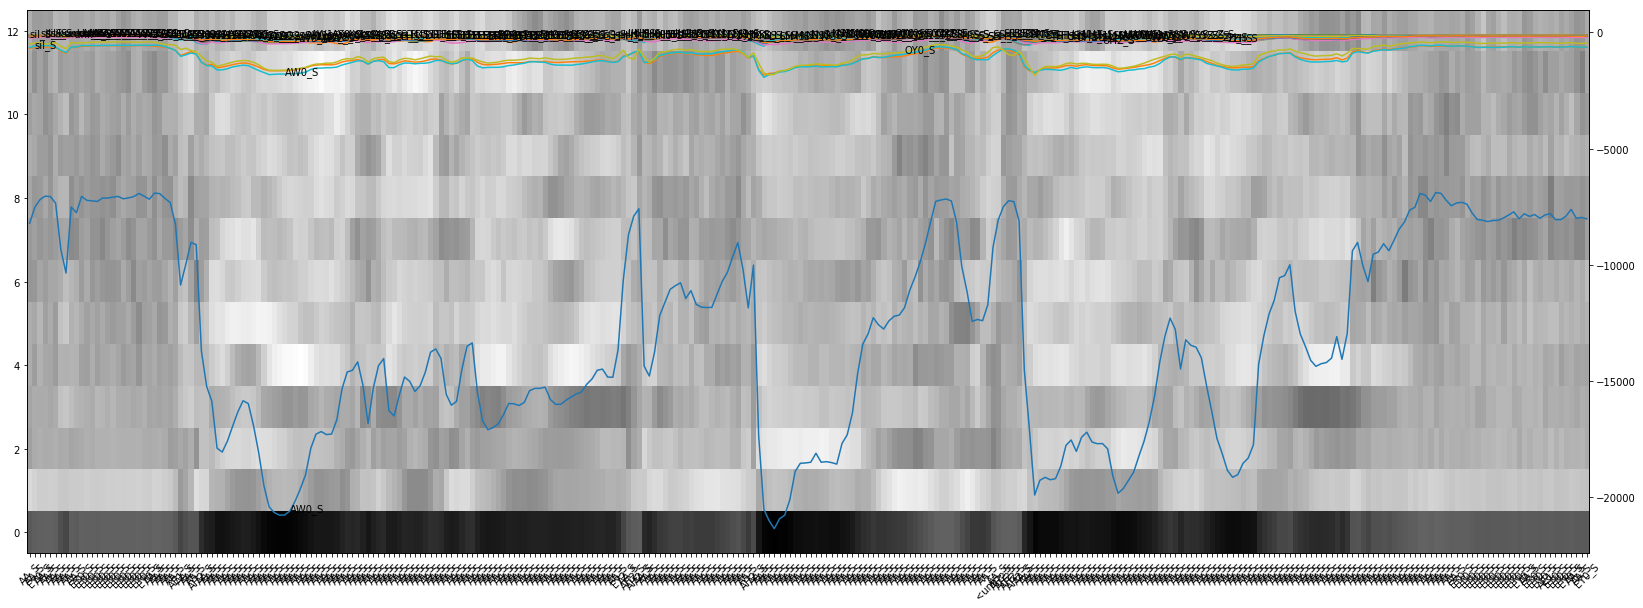

In [236]:
# all phones
ph_seq = []
argmax = np.argmax(likes, axis=1)
for m in argmax:
    ph_seq.append(K.pdf[m])
    
plot_mfcc_likes(mfcc, likes, ph_seq)        

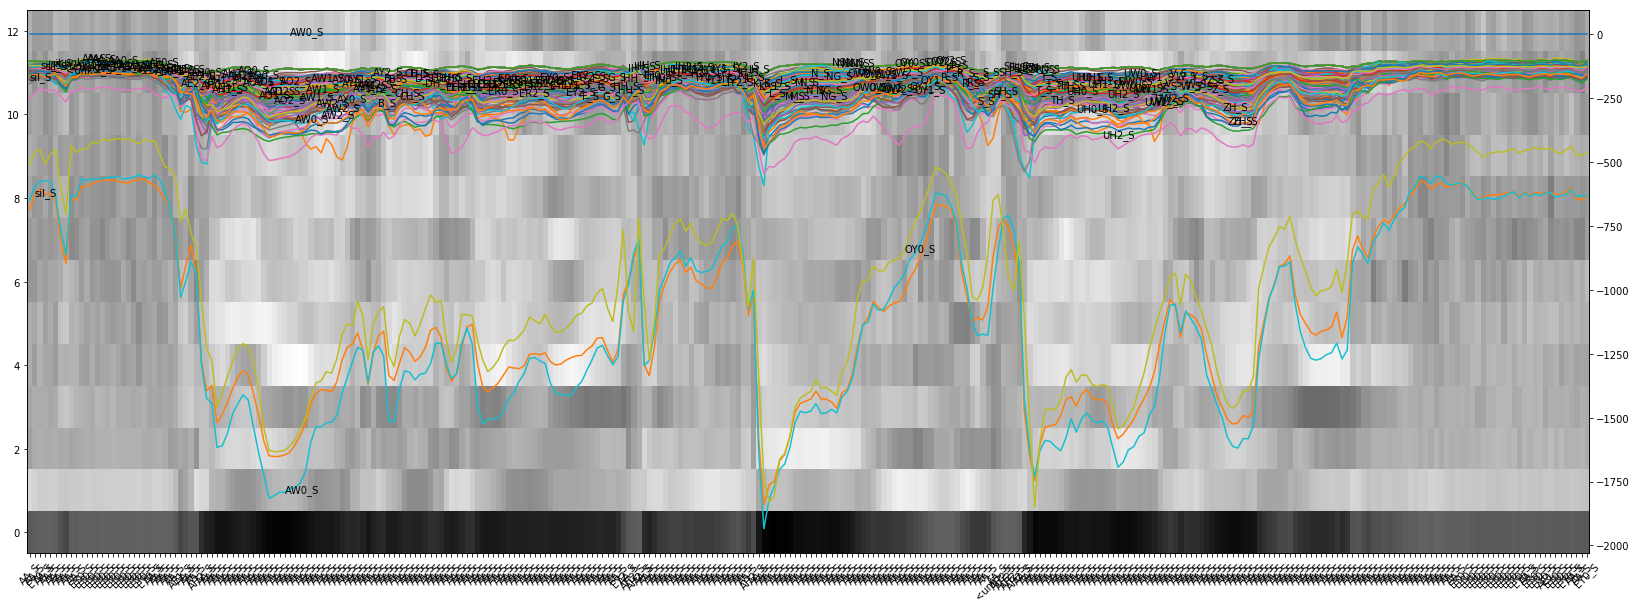

In [237]:
# zeros AW0_S (50)
likes_no_50 = np.copy(likes)
likes_no_50[:,50] = 0
ph_seq = []
argmax = np.argmax(likes, axis=1)
for m in argmax:
    ph_seq.append(K.pdf[m])
    
plot_mfcc_likes(mfcc, likes_no_50, ph_seq)

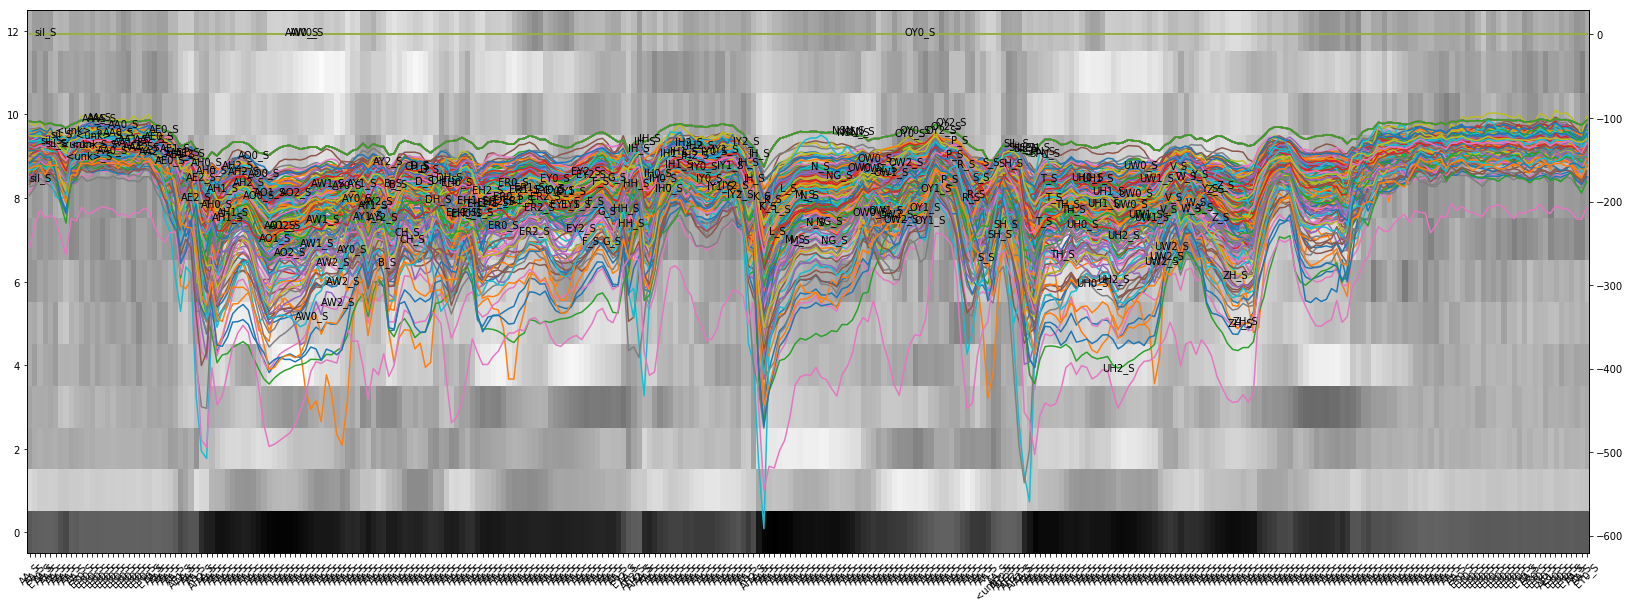

In [238]:
# zeros 50 + 1, 49, 168
likes_no_4 = np.copy(likes)
likes_no_4[:,50] = 0
likes_no_4[:,1] = 0
likes_no_4[:,49] = 0
likes_no_4[:,168] = 0
ph_seq = []
argmax = np.argmax(likes, axis=1)
for m in argmax:
    ph_seq.append(K.pdf[m])
    
plot_mfcc_likes(mfcc, likes_no_4, ph_seq)

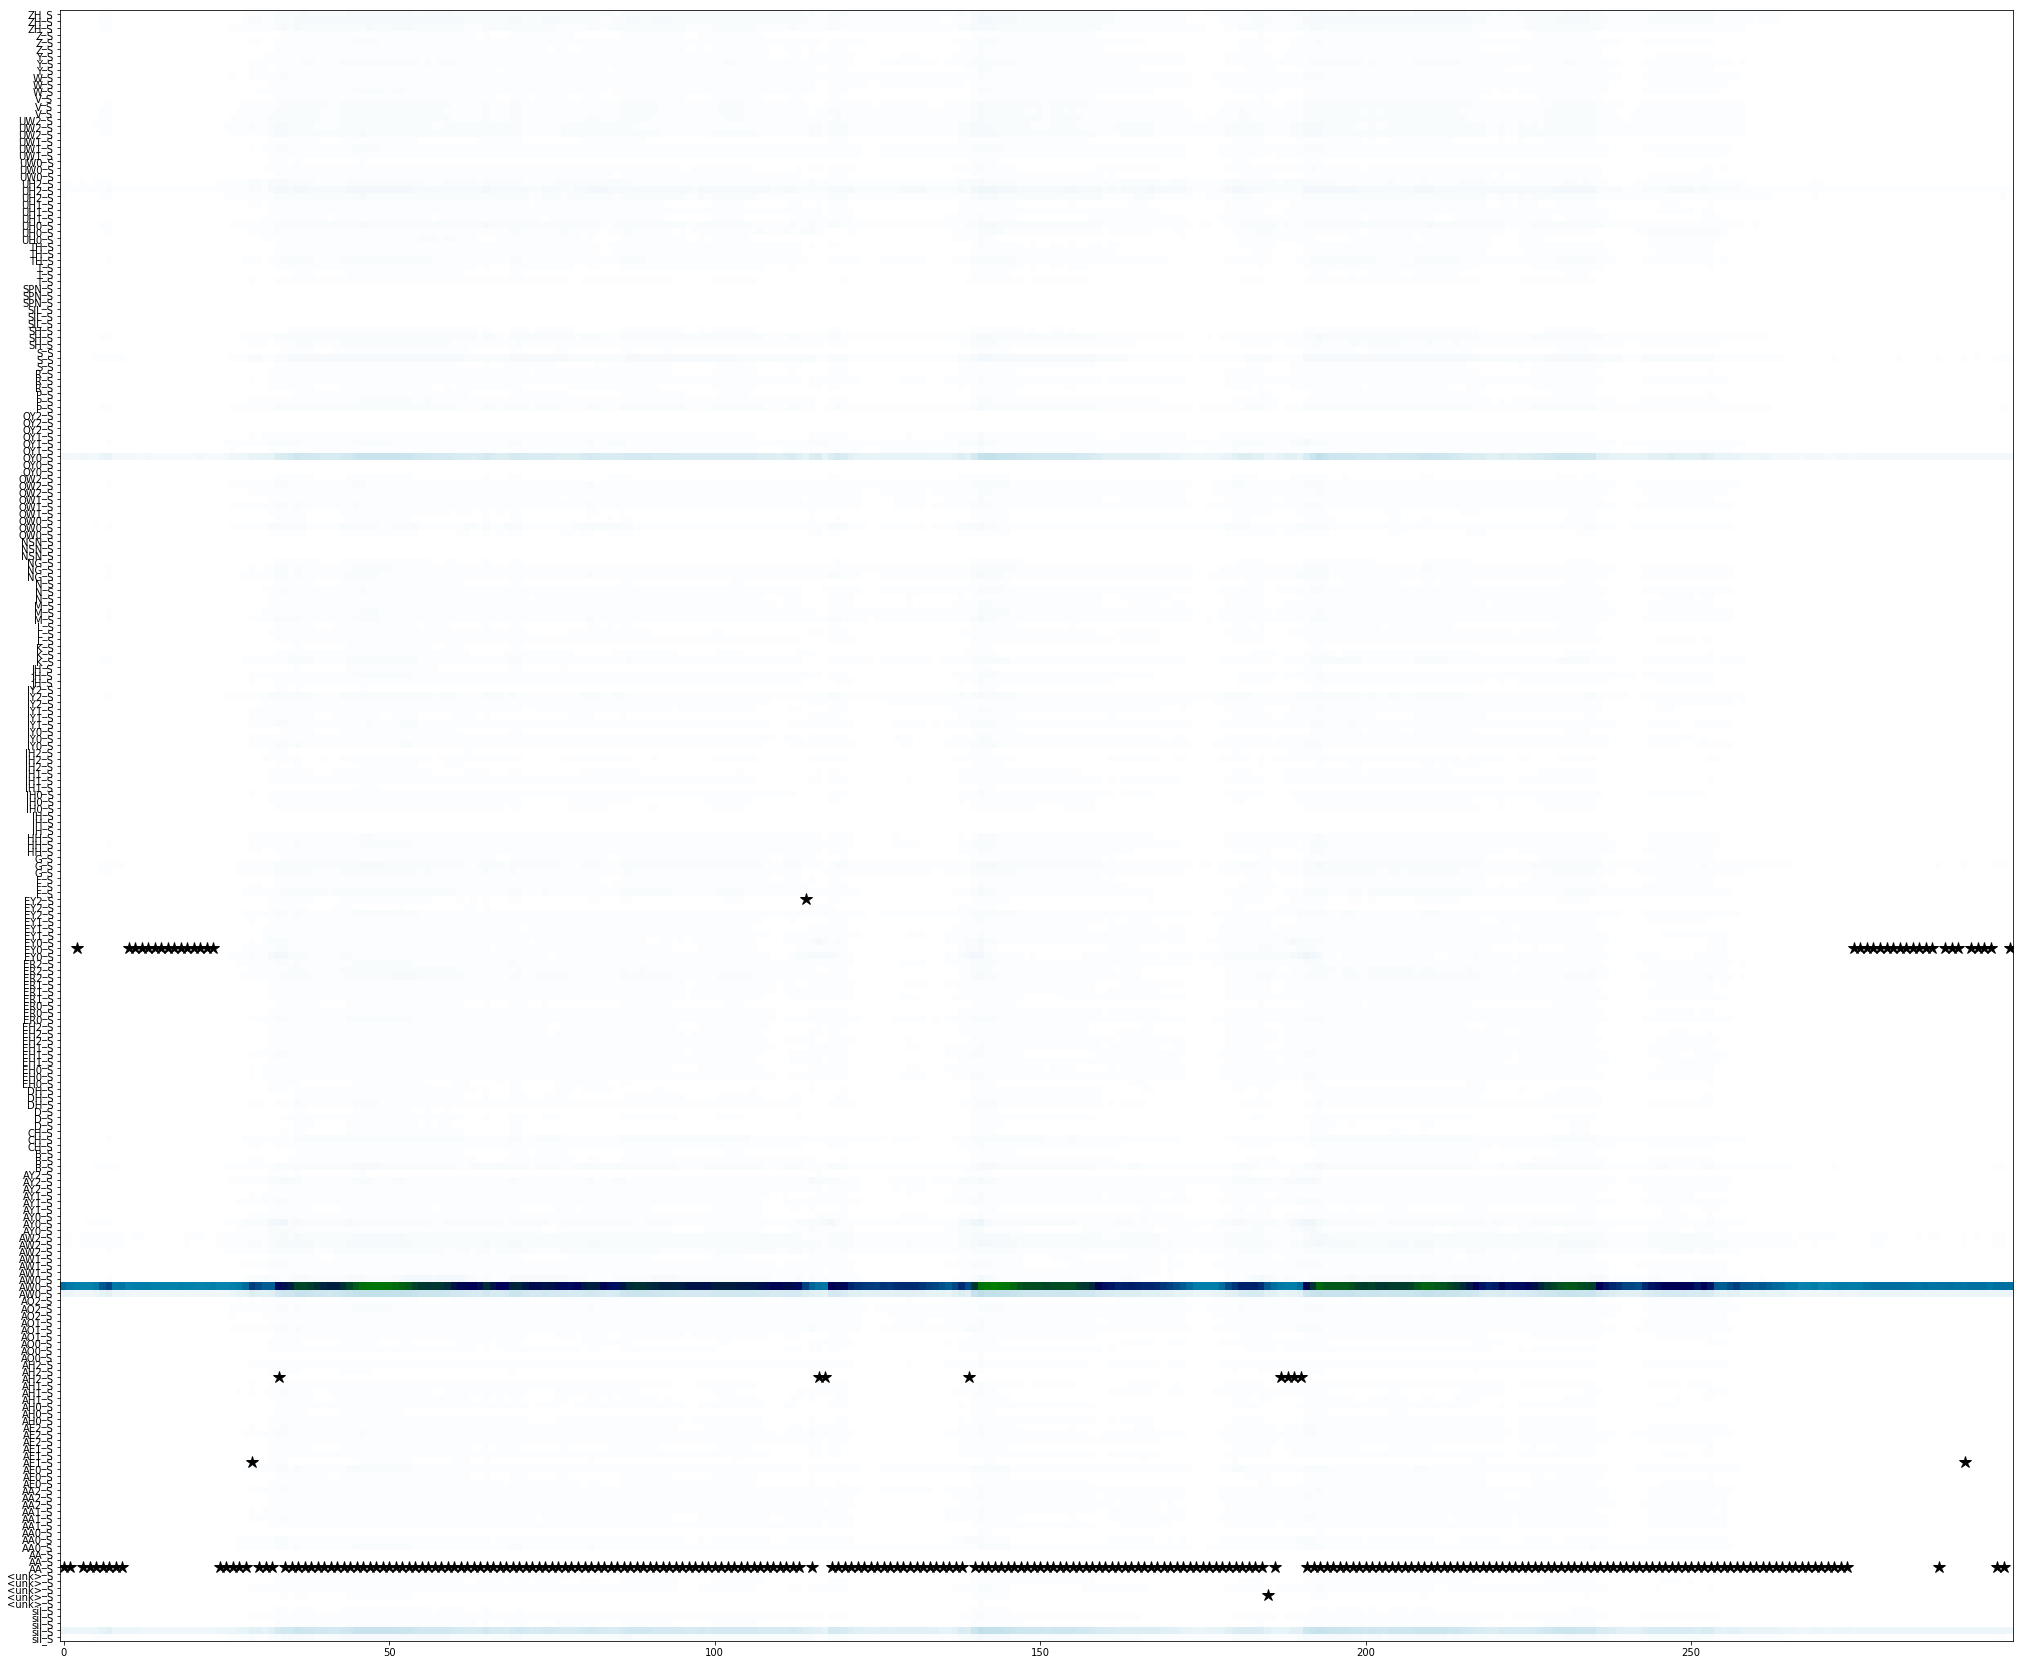

In [250]:
def plot_heatmap(likes, pdf_dic=K.pdf):
    fig, ax = plt.subplots(figsize=(35,30), facecolor='white')
    ax.imshow(likes.T, origin='lower', aspect='auto', cmap='ocean')
    ax.set_yticks(range(likes.shape[1]))
    ax.set_yticklabels([pdf_dic[p][0] for p in sorted(list(pdf_dic.keys()))])
    argmax = np.argmax(likes, axis=1)
    ax.plot(np.arange(likes.shape[0]), argmax, 'ro', markersize=12)

plot_heatmap(likes)